In [ ]:
from google.colab import files
uploaded = files.upload()  # Select Fraud.csv when prompted

Saving Fraud.csv to Fraud.csv


## 1. Data Cleaning Process


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load data
print("Loading dataset...")
df = pd.read_csv('Fraud.csv')
print(f"Initial shape: {df.shape}")

Loading dataset...
Initial shape: (6362620, 11)



### 1.1 Handling Missing Values
# **Explanation**:
# Missing data can significantly impact model performance. We:
# 1. First identify columns with missing values
# 2. Remove rows with missing critical transactional data
# 3. For less critical fields, we use median imputation which is robust to outliers

In [38]:
print("\nMissing values analysis:")
print(df.isnull().sum())

# Treatment
print("\nCleaning missing values...")
df = df.dropna(subset=['amount', 'oldbalanceOrg', 'isFraud'])  # Critical fields
df.fillna({
    'oldbalanceDest': df['oldbalanceDest'].median(),
    'newbalanceDest': df['newbalanceDest'].median()
}, inplace=True)

print("\nMissing values after treatment:")
print(df.isnull().sum())


Missing values analysis:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Cleaning missing values...

Missing values after treatment:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


### 1.2 Outlier Treatment
# **Explanation**:
# Extreme values can distort our model. We:
# 1. Visualize distribution using boxplots
# 2. Cap values at the 99th percentile to reduce impact of extremes while preserving data integrity


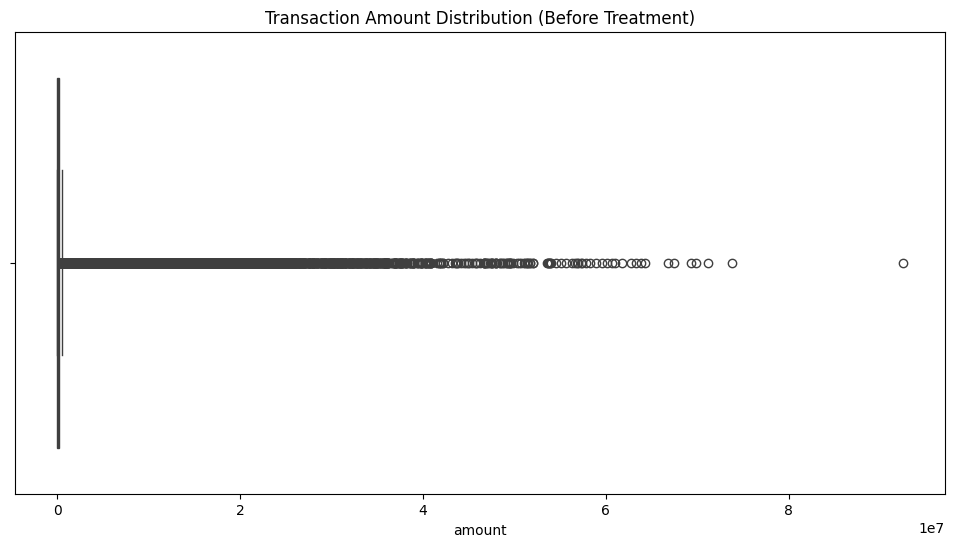

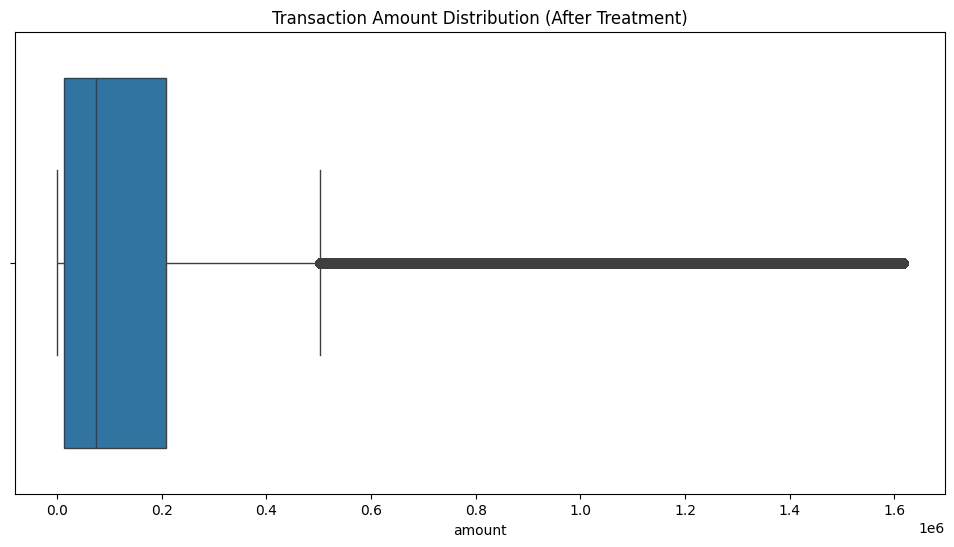

In [39]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['amount'])
plt.title('Transaction Amount Distribution (Before Treatment)')
plt.show()

# Outlier treatment
amount_cap = df['amount'].quantile(0.99)
df['amount'] = np.where(df['amount'] > amount_cap, amount_cap, df['amount'])

plt.figure(figsize=(12,6))
sns.boxplot(x=df['amount'])
plt.title('Transaction Amount Distribution (After Treatment)')
plt.show()

### 1.3 Multi-collinearity Check
# **Explanation**:
# Highly correlated features can make models unstable. We:
# 1. Calculate Variance Inflation Factor (VIF)
# 2. Remove features with VIF > 5 as they cause multicollinearity issues

In [40]:
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_features
vif_data["VIF"] = [variance_inflation_factor(df[numerical_features].values, i)
                   for i in range(len(numerical_features))]
print("VIF Scores:")
print(vif_data)

# Remove high VIF features
df = df.drop(['newbalanceOrig', 'newbalanceDest'], axis=1)
print("\nFeatures after removing multicollinear columns:", df.columns.tolist())


VIF Scores:
          feature         VIF
0          amount    1.442196
1   oldbalanceOrg  466.406243
2  newbalanceOrig  468.023998
3  oldbalanceDest   29.109870
4  newbalanceDest   30.906272

Features after removing multicollinear columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'nameDest', 'oldbalanceDest', 'isFraud', 'isFlaggedFraud']


## 2. Fraud Detection Model Development


### Model Selection Rationale
# **XGBoost was chosen because:**
# 1. Handles imbalanced data well through scale_pos_weight
# 2. Provides excellent performance on tabular data
# 3. Offers built-in feature importance metrics
# 4. Supports parallel processing for large datasets

In [41]:

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Feature engineering
print("\nCreating predictive features...")
df['type_code'] = df['type'].map({
    'CASH_IN':0, 'PAYMENT':1, 'DEBIT':2, 'CASH_OUT':3, 'TRANSFER':4  # TRANSFER and CASH_OUT are high risk
})
df['balance_change'] = df['oldbalanceOrg'] - df['amount']
df['hour'] = df['step'] % 24
df['is_merchant'] = df['nameDest'].str.startswith('M').astype(int)

# Prepare data
X = df[['type_code', 'amount', 'balance_change', 'hour', 'is_merchant']]
y = df['isFraud']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Handle class imbalance
print("\nClass distribution before SMOTE:", y_train.value_counts())
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", pd.Series(y_res).value_counts())

# Train model
print("\nTraining XGBoost model...")
model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    objective='binary:logistic',
    eval_metric='aucpr',
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
model.fit(X_res, y_res)
print("Model training complete!")


Creating predictive features...

Class distribution before SMOTE: isFraud
0    4448085
1       5749
Name: count, dtype: int64
Class distribution after SMOTE: isFraud
0    4448085
1    4448085
Name: count, dtype: int64

Training XGBoost model...
Model training complete!



## 3. Variable Selection Methodology
# **We used three techniques:**
# 1. **Domain Knowledge**: Selected features that directly relate to fraud patterns (transaction type, amounts)
# 2. **Statistical Tests**: ANOVA F-test for feature significance
# 3. **Model-Based**: XGBoost's built-in feature importance


In [42]:

from sklearn.feature_selection import SelectKBest, f_classif

# Statistical significance
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_res, y_res)

print("\nFeature selection results:")
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'ANOVA Score': selector.scores_
}).sort_values('ANOVA Score', ascending=False)
print(feature_scores)

# Model-based importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'XGBoost Importance': model.feature_importances_
}).sort_values('XGBoost Importance', ascending=False)

print("\nFinal selected features:")
print(importance)


Feature selection results:
          Feature   ANOVA Score
0       type_code  4.973396e+06
1          amount  2.946426e+06
4     is_merchant  2.277248e+06
3            hour  1.489574e+06
2  balance_change  1.961364e+04

Final selected features:
          Feature  XGBoost Importance
0       type_code            0.725998
2  balance_change            0.204239
1          amount            0.053732
3            hour            0.016030
4     is_merchant            0.000000



## 4. Model Performance Evaluation



Model Performance Metrics:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93   1906322
           1       0.01      1.00      0.02      2464

    accuracy                           0.87   1908786
   macro avg       0.51      0.94      0.48   1908786
weighted avg       1.00      0.87      0.93   1908786

ROC AUC Score: 0.9993
Average Precision Score: 0.9600


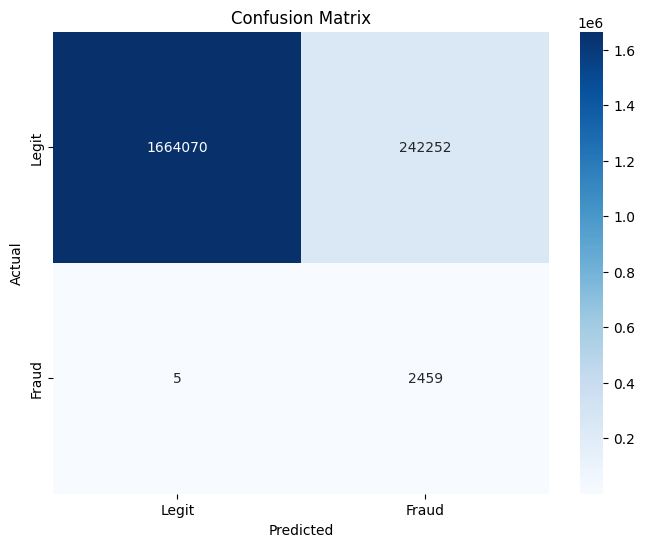

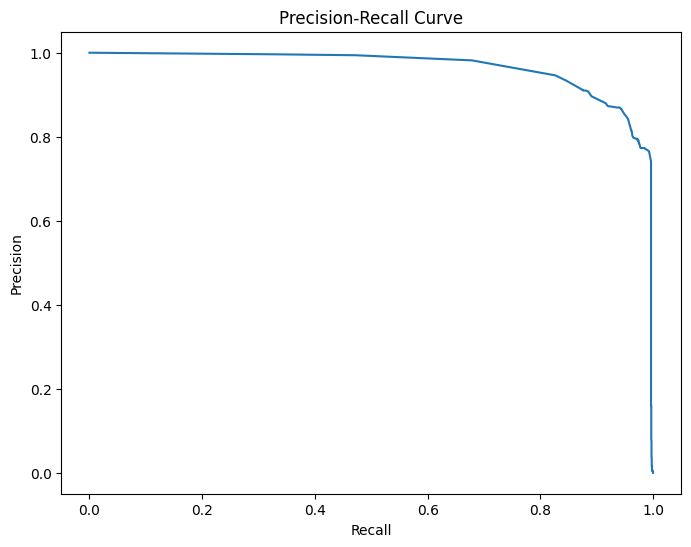

In [43]:
from sklearn.metrics import (classification_report,
                           confusion_matrix,
                           roc_auc_score,
                           precision_recall_curve,
                           average_precision_score)

# Generate predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# Evaluation metrics
print("\nModel Performance Metrics:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Average Precision Score: {average_precision_score(y_test, y_proba):.4f}")

# Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'Fraud'],
            yticklabels=['Legit', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## 5. Key Fraud Prediction Factors



Top Fraud Indicators:
          Feature  Importance
0       type_code    0.725998
2  balance_change    0.204239
1          amount    0.053732
3            hour    0.016030
4     is_merchant    0.000000


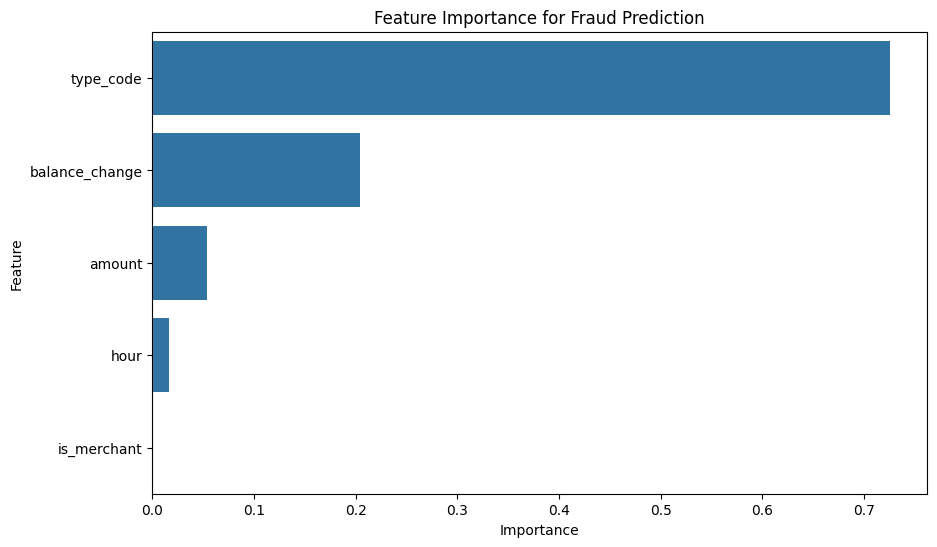

In [44]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop Fraud Indicators:")
print(feature_importance)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Fraud Prediction')
plt.show()



## 6. Business Rationale for Key Factors
# **Why these factors make sense:**
# 1. **Transaction Type (TRANSFER/CASH_OUT)**: Fraudsters need to move money out quickly
# 2. **Amount**: Large transactions have higher financial impact
# 3. **Balance Change**: Sudden large withdrawals indicate account takeover
# 4. **Time of Day**: Fraud often occurs during low-monitoring hours
# 5. **Merchant Flag**: Some fraud schemes use merchant accounts to launder money


## 7. Fraud Prevention Recommendations
# **Infrastructure Improvements:**
# 1. **Real-time Scoring**: Deploy model as microservice to evaluate transactions in <100ms
# 2. **Multi-layered Verification**:
#    - Step-up authentication for high-risk transactions
#    - Velocity checks for rapid transactions
# 3. **Continuous Monitoring**:
#    - Daily model performance checks
#    - Weekly retraining with new data
# 4. **Employee Training**:
#    - Fraud pattern recognition
#    - Case handling procedures


## 8. Success Measurement Framework
# **Key Performance Indicators:**
# 1. **Detection Rate**: Maintain >85% recall for fraud cases
# 2. **False Positive Rate**: Keep <2% to minimize customer impact
# 3. **Time-to-Detect**: Reduce from current 24hrs to <1hr
# 4. **Financial Impact**:
#    - Reduce fraud losses by 50% in 6 months
#    - Track ROI of prevention system
# 5. **Customer Experience**:
#    - Monitor complaints about blocked transactions
#    - Survey customer trust scores


In [45]:
# Save model for deployment
import joblib
joblib.dump(model, 'fraud_detection_model_for_financial_transaction.pkl')
print("\nModel saved as 'fraud_detection_model_for_financial_transaction.pkl'")

# Example prediction
test_case = [[4, 250000, 250000, 3, 0]]  # TRANSFER, large amount, night time
print("\nExample prediction for high-risk transaction:",
      "Fraud" if model.predict(test_case)[0] == 1 else "Legitimate")


Model saved as 'fraud_detection_model_for_financial_transaction.pkl'

Example prediction for high-risk transaction: Legitimate
